In [1]:
# !pip install tensorflow_similarity

In [2]:
import numpy as np
import tensorflow as tf
import scipy as scp
import sklearn as skl
# from tensorflow_similarity.models import SimilarityModel

In [3]:
n = 10000

scale = 3 
mu1 = scale*np.array([-1.5396,-1.5396])
sigma1 = np.array([[0.5,0],[0,2]])

mu2 = scale*np.array([0,1])
sigma2 = np.array([[3,0],[0,1/3]])

mu3 = scale*np.array([1.5396,-1.5396])
sigma3 = np.array([[1,0],[0,1]])

x1 = np.random.multivariate_normal(mean = mu1, cov = sigma1, size = n)
y1 = np.array([[1.0,0.0,0.0] for i in range(n)])

x2 = np.random.multivariate_normal(mean = mu2, cov = sigma2, size = n)
y2 = np.array([[0.0,1.0,0.0] for i in range(n)])

x3 = np.random.multivariate_normal(mean = mu3, cov = sigma3, size = n)
y3 = np.array([[0.0,0.0,1.0] for i in range(n)])


X = np.concatenate([x1,x2,x3])
Y = np.concatenate([y1,y2,y3])

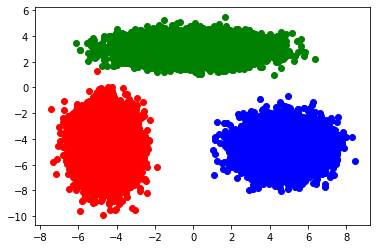

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x1[:,0],x1[:,1], c = "red")
plt.scatter(x2[:,0],x2[:,1], c = "green")
plt.scatter(x3[:,0],x3[:,1], c = "blue")
plt.show()

In [5]:
# def augmentation1(x):
#     return np.multiply(x+np.random.multivariate_normal(mean = np.array([-0.2,0.4]), cov = 0.1*np.array([[1,0],[0,1]]), size = x.reshape((-1,2)).shape[0]),[0.3,1.2])
    
# # def augmentation2(x):
# #     a = np.random.normal( 2, 0.1)
# #     b = np.random.normal( 1, 0.5)
# #     c = np.random.normal( 0, 1)
# #     return np.multiply(x,[a,-b])+c

# def augmentation2(x):
#     return np.multiply(x+np.random.multivariate_normal(mean = np.array([0,-0]), cov = 10*np.array([[1,0],[0,1]]), size = x.reshape((-1,2)).shape[0]),[-30,-30])


In [6]:
np.pi

3.141592653589793

In [7]:
def augmentation1(x):
    theta = np.sqrt(3)*np.pi/4
    return np.dot(np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]]),x.T).T +np.random.multivariate_normal(mean = np.array([-0.2,0.4]), cov = 0.3*np.array([[1,0],[0,1]]))

def augmentation2(x):
    theta = -np.sqrt(3)*np.pi/4
    return np.dot(np.array([[-np.cos(theta),np.sin(theta)],[np.sin(theta),-np.cos(theta)]]),x.T).T +np.random.multivariate_normal(mean = np.array([0.1,-0.3]), cov = 0.2*np.array([[1,0],[0,1]]))

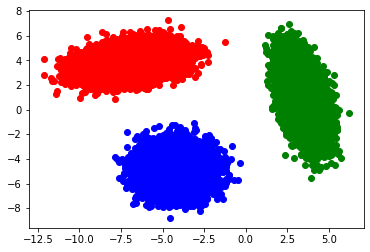

In [8]:
x1_aug1 = augmentation1(x1)

x2_aug1 = augmentation1(x2)

x3_aug1 = augmentation1(x3)

X_aug1 = np.concatenate([x1_aug1,x2_aug1,x3_aug1])
plt.scatter(x1_aug1[:,0],x1_aug1[:,1], c = "red")
plt.scatter(x2_aug1[:,0],x2_aug1[:,1], c = "green")
plt.scatter(x3_aug1[:,0],x3_aug1[:,1], c = "blue")
plt.show()

In [9]:
np.abs(X_aug1).max(axis = 0)

array([12.12225309,  8.77535766])

In [10]:
X_aug1 = X_aug1/np.abs(X_aug1).max(axis = 0)

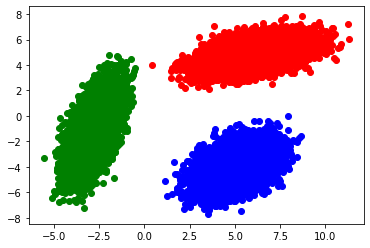

In [11]:
x1_aug2 = augmentation2(x1)

x2_aug2 = augmentation2(x2)

x3_aug2 = augmentation2(x3)

X_aug2 = np.concatenate([x1_aug2,x2_aug2,x3_aug2])
X_aug2 = X_aug2/np.abs(X_aug2).max(axis = 0)
plt.scatter(x1_aug2[:,0],x1_aug2[:,1], c = "red")
plt.scatter(x2_aug2[:,0],x2_aug2[:,1], c = "green")
plt.scatter(x3_aug2[:,0],x3_aug2[:,1], c = "blue")
plt.show()

In [12]:
def softmax_stable(x, axis = None):
    return(np.exp(x - np.max(x, axis =  axis)) / np.exp(x - np.max(x,axis =  axis)).sum())

def naiv_unif_prior_crossentropy(y_preds):
    s1 = softmax_stable(y_preds[0])
    s2 = softmax_stable(y_preds[1])
    
    l1 = -np.sum(s2 * np.log(s1))
    l2 = -np.sum(s1 * np.log(s2))
    
    return  ( l1 + l2 ) / 2

def tf_naiv_unif_prior_crossentropy(y_true, y_preds):
   
    l1 = tf.nn.softmax_cross_entropy_with_logits(labels=y_preds[0],logits=y_preds[1])
    l2 = tf.nn.softmax_cross_entropy_with_logits(labels=y_preds[1],logits=y_preds[0])
    
    return  tf.math.reduce_sum(( l1 + l2 ) / 2)


In [13]:
batch_size = 500
nb_classes = 3
def make_dummy_data(nb_classes = nb_classes):
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=2*batch_size)
        ds = ds.batch(batch_size=batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
        
        
    X = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_aug1), tf.data.Dataset.from_tensor_slices(X_aug2)))
    y =  tf.data.Dataset.from_tensor_slices(Y)
   

    ds = tf.data.Dataset.zip((X,y))
    ds = configure_for_performance(ds)
    return ds

In [14]:
def tf_unif_prior_crossentropy(pred1,pred2):
    N = batch_size
    C = 3
    
    t_c = 0.1
    t_r = 0.1
    
    a = tf.nn.softmax(pred2/t_c, axis=0)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part11 = c
    d = tf.nn.softmax(pred1/t_r, axis=1)
    part21 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)), (-1,C))
    loss_1 = -tf.math.reduce_sum( part11 * part21 , axis=-1)
    
    a = tf.nn.softmax(pred1/t_c)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part12 = c
    d = tf.nn.softmax(pred2/t_r, axis=1)
    part22 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)),(-1,C))
    loss_2 = -tf.math.reduce_sum( part12*part22 , axis=-1)

    return tf.math.reduce_mean(1/2*(loss_1+loss_2))

In [18]:
avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

class custom_fit(tf.keras.Model):
    def train_step(self, data):
        input_data, labels = data
#         print(input_data)
        with tf.GradientTape() as tape:
            outputs = self(input_data, training=True) # forward pass 
            pred1 = outputs[0]
            pred2 = outputs[1]
#             print(outputs)
#             print("loss 1 : ",single_loss(pred1,pred2))
#             print("loss 2 : ",single_loss(pred2,pred1))
#             total_loss = tf.math.reduce_sum(1/2*(single_loss(pred1,pred2)+single_loss(pred2,pred1)))
            total_loss = tf_unif_prior_crossentropy(pred1,pred2)
            print("sum : ",total_loss)
#             with tf.Session() as sess:  print(total_loss.eval()) 
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        avg_loss.update_state(total_loss)
        return {"loss": avg_loss.result()}
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [avg_loss]

In [19]:
# class CustomLoss(tf.keras.losses.Loss):
#   def __init__(self):
#     super().__init__()
#   def call(self, y_true, y_pred):
#     return  tf_unif_prior_crossentropy(y_true, y_pred)
# class CustomLoss(tf.keras.losses.Loss):
#   def __init__(self):
#     super().__init__()
#   def call(self, y_true, y_pred):
#     preds = tf.math.reduce_mean(y_pred, axis = 1)
#     return  tf.keras.losses.MeanSquaredError()(y_true = y_true,y_pred=  preds)

def create_model_aux(dropout = 0.5):
    layer_input = tf.keras.layers.Input(shape=(2), dtype=tf.float32)
    first_layer = tf.keras.layers.Dense(16, activation = "relu", dtype=tf.float16)(layer_input)
    first_layer = tf.keras.layers.Dropout(dropout, dtype=tf.float16)(first_layer)
#     first_layer = tf.keras.layers.Dense(4, activation = "relu", dtype=tf.float16)(first_layer)
#     first_layer = tf.keras.layers.Dropout(dropout, dtype=tf.float16)(first_layer)
#     first_layer = tf.keras.layers.Dense(2, activation = "relu", dtype=tf.float16)(first_layer)
#     first_layer = tf.keras.layers.Dropout(dropout, dtype=tf.float16)(first_layer)
    output = tf.keras.layers.Dense(3,activation = None,)(first_layer)
    output = tf.keras.layers.Dropout(dropout)(output)
    output = tf.keras.layers.Activation("softmax")(output)
    model = tf.keras.models.Model(inputs=layer_input, outputs= output)
    return model

def create_model():
    model_shared = create_model_aux()
    input_x1 = tf.keras.layers.Input(shape=(2), dtype=tf.float32)
    input_x2 = tf.keras.layers.Input(shape=(2), dtype=tf.float32)
    output_x1 = model_shared(input_x1)
    output_x2 = model_shared(input_x2)
#     output = tf.keras.layers.Average()([output_x1, output_x2])
#     model = tf.keras.models.Model(inputs=[input_x1,input_x2], outputs = output)
    model = custom_fit(inputs=[input_x1,input_x2], outputs = [output_x1,output_x2])
    model.compile(loss=tf_unif_prior_crossentropy,metrics=[],optimizer = "RMSprop")
    return model

In [20]:
# from sklearn.model_selection import train_test_split
# X_train, X_test,y_train, y_test = train_test_split(X,Y, train_size = 0.8)

In [21]:
ds = make_dummy_data()

In [22]:
lr_min = 1e-6
lr_max = 5*1e-3

def my_cosine_decay(epoch,
                    epoch_max=5,
                    LR_START = 0.0001/2,
                    LR_MAX =  lr_max,
                    LR_MIN = lr_min,
                    LR_RAMPUP_EPOCHS = 3,
                    LR_SUSTAIN_EPOCHS = 0,
                    LR_ALPHA_DECAY = .7
                   ):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        cosine_decay=max(0.5*(1+np.cos(np.pi*((epoch-LR_RAMPUP_EPOCHS)/epoch_max))),LR_MIN)
        decayed=(1-LR_ALPHA_DECAY)*cosine_decay+LR_ALPHA_DECAY
        learning_rate=LR_MAX*decayed
    return learning_rate

def lr_decay(epoch,
            LR_START = lr_max/2,
            LR_MAX =  lr_max,
            LR_MIN = lr_min,
            LR_RAMPUP_EPOCHS = 3,
            LR_SUSTAIN_EPOCHS = 0,
            LR_ALPHA_DECAY = .05
                   ):
    learning_rate=max(LR_MAX*np.exp(-LR_ALPHA_DECAY*epoch), LR_MIN)
    return learning_rate
   

def my_clr(epoch,
           epoch_cycle = 8,
           LR_MIN = lr_min,
           LR_MAX = lr_max,
           LR_ALPHA_DECAY = .99):
    nb_cycle = epoch // epoch_cycle
    k=0
    while k < nb_cycle :
        LR_MAX = (LR_MAX+ LR_MIN)*LR_ALPHA_DECAY
        k += 1
    if epoch % epoch_cycle < epoch_cycle//2 :
        learning_rate = (LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MIN
    else :
        learning_rate = -(LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MAX
    return learning_rate
    
lrfn=lambda epoch : my_clr(
       epoch,
        LR_MIN = lr_min,
        LR_MAX = lr_max
    )
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=32,verbose=1)

In [23]:
# test_model = create_model_aux()
# test_model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer = "Adam")
test_model = create_model()
history = test_model.fit(x = ds,  epochs = 2000,callbacks = [lr_callback, early_stopper],validation_batch_size=batch_size,steps_per_epoch= int(len(X)/batch_size))
# history = test_model.fit(x = X_train,y = y_train,validation_data = (X_test, y_test),  epochs = 10, steps_per_epoch= int(len(X)/batch_size)+1)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/2000
sum :  Tensor("Mean:0", shape=(), dtype=float32)
sum :  Tensor("Mean:0", shape=(), dtype=float32)
60/60 [==============================] - 2s 7ms/step - loss: 1.4740 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.00125075.
Epoch 2/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.3409 - lr: 0.0013

Epoch 3: LearningRateScheduler setting learning rate to 0.0025005.
Epoch 3/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.1686 - lr: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.00375025.
Epoch 4/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.1085 - lr: 0.0038

Epoch 5: LearningRateScheduler setting learning rate to 0.005.
Epoch 5/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.0991 - lr: 0.0050

Epoch 6: LearningRateScheduler setting learning rate to 0.00375025.
Epoch 6/2000
60/60 [=====

Epoch 48/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.0986 - lr: 0.0012

Epoch 49: LearningRateScheduler setting learning rate to 1e-06.
Epoch 49/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.0986 - lr: 1.0000e-06

Epoch 50: LearningRateScheduler setting learning rate to 0.0011790485530535754.
Epoch 50/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.0986 - lr: 0.0012

Epoch 51: LearningRateScheduler setting learning rate to 0.002357097106107151.
Epoch 51/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.0986 - lr: 0.0024

Epoch 52: LearningRateScheduler setting learning rate to 0.003535145659160727.
Epoch 52/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.0986 - lr: 0.0035

Epoch 53: LearningRateScheduler setting learning rate to 0.004713194212214302.
Epoch 53/2000
60/60 [==============================] - 0s 8ms/step - loss: 1.0986 - lr: 0.0047

Epoch 54: LearningRateScheduler setting

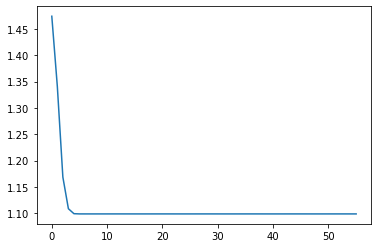

In [24]:
plt.plot(history.history["loss"])

In [35]:
X_test = X/np.abs(X).max(axis = 0)
y_predict = test_model.predict( [X_aug1,X_aug2])

In [36]:
y_predict_labels =y_predict[0][:].argmax(axis = 1)

In [37]:
y_predict_labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [38]:
# X_test[y_predict_labels[:]==2]
x_test_1 = X[y_predict_labels[:]==0]
x_test_2 = X[y_predict_labels[:]==1]
x_test_3 = X[y_predict_labels[:]==2]

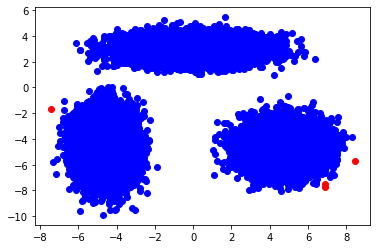

In [39]:
plt.scatter(x_test_1[:,0],x_test_1[:,1], c = "red")
plt.scatter(x_test_2[:,0],x_test_2[:,1], c = "green")
plt.scatter(x_test_3[:,0],x_test_3[:,1], c = "blue")
plt.show()